In [69]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel, BiphasicAxonMapSpatial
from pulse2percept.implants import ArgusII
from pulse2percept.viz import scatter_correlation
import shapes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import math
from scipy.optimize import curve_fit

In [2]:
data = shapes.load_shapes("../data/shapes.h5", implant='ArgusII', stim_class=['MultiElectrode', 'SpatialSummation'])
data.head()

,subject,amp1,amp2,area,compactness,date,eccentricity,elec_delay,electrode1,electrode2,...,image,implant,num_regions,orientation,pdur,stim_class,trial,x_center,y_center,img_shape
0,12-005,1.5,1.5,434,0.783044,20091028,0.700223,0.0,A10,C10,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,-0.150516,0.45,MultiElectrode,1,256.0,192.0,"(384, 512)"
1,12-005,1.5,1.5,595,0.536552,20091028,0.713548,0.0,A10,C10,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,-0.760744,0.45,MultiElectrode,15,256.0,192.0,"(384, 512)"
2,12-005,1.5,1.5,459,0.465158,20091028,0.753356,0.0,A10,C10,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.341745,0.45,MultiElectrode,33,256.0,192.0,"(384, 512)"
3,12-005,1.5,1.5,114,0.311651,20091028,0.927572,0.0,A10,C10,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,0.138759,0.45,MultiElectrode,37,256.0,192.0,"(384, 512)"
4,12-005,1.5,1.5,435,0.407359,20091028,0.833744,0.0,A10,C10,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",ArgusII,1,-0.589053,0.45,MultiElectrode,60,256.0,192.0,"(384, 512)"


In [3]:
# load all the data up
for subject in data['subject'].unique():
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
    locs = data['subject'] == subject
    subj_data = data.loc[locs]
    data.loc[locs,['d_retina', 'd_perp_avg', 'd_tan_avg']] = shapes.dist_perpendicular_tangential(subj_data['electrode1'].to_numpy(), subj_data['electrode2'].to_numpy(), implant, model, strategy='average')
    data.loc[locs,['d_retina', 'd_perp', 'd_tan']] = shapes.dist_perpendicular_tangential(subj_data['electrode1'].to_numpy(), subj_data['electrode2'].to_numpy(), implant, model, strategy='upstream')
    data.loc[locs,['d_retina', 'd_across_axonal', 'd_along_axonal']] = shapes.dist_across_along(subj_data['electrode1'].to_numpy(), subj_data['electrode2'].to_numpy(), implant, model, strategy='axonal')
    data.loc[locs,['d_retina', 'd_across_radial', 'd_along_radial']] = shapes.dist_across_along(subj_data['electrode1'].to_numpy(), subj_data['electrode2'].to_numpy(), implant, model, strategy='radial')
    data.loc[locs,['d_retina', 'd_across_mixed', 'd_along_mixed']] = shapes.dist_across_along(subj_data['electrode1'].to_numpy(), subj_data['electrode2'].to_numpy(), implant, model, strategy='mixed')


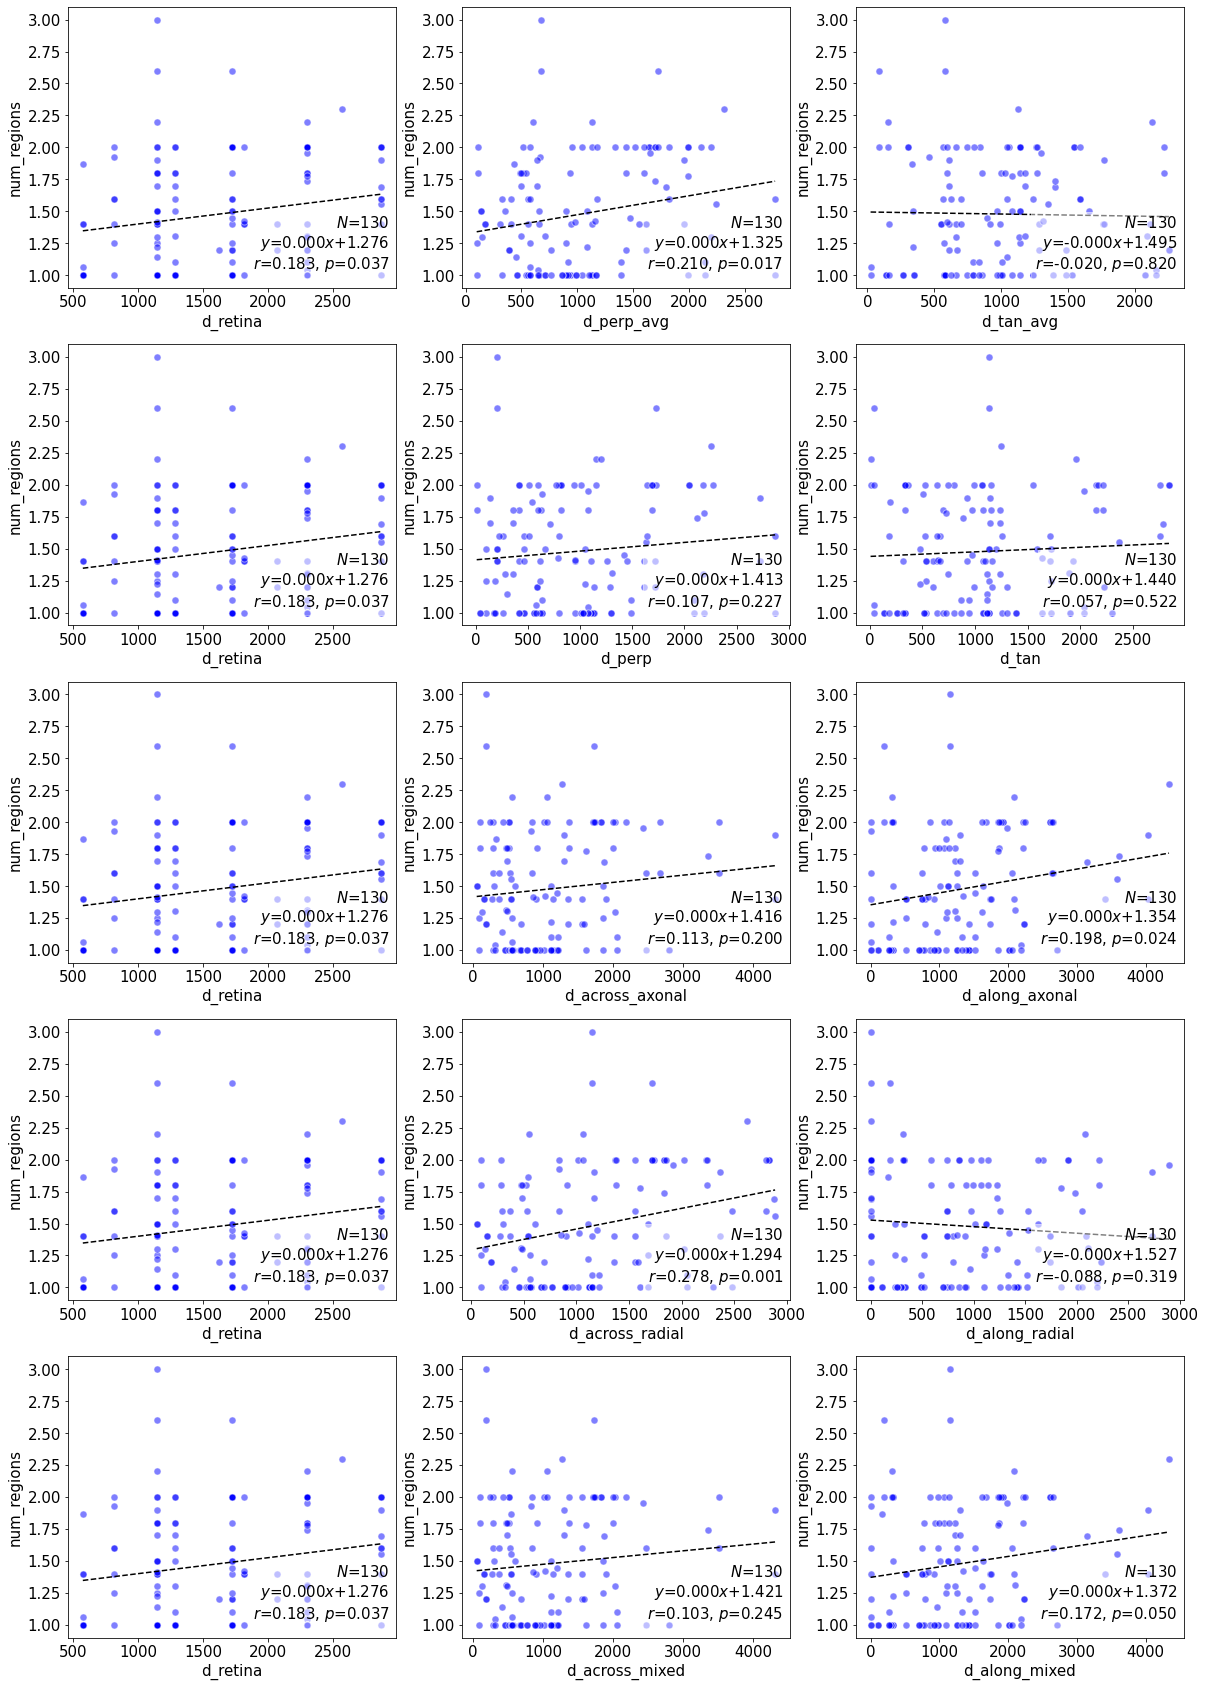

In [64]:
%matplotlib inline
cols = [['d_retina', 'd_perp_avg', 'd_tan_avg'],
    ['d_retina', 'd_perp', 'd_tan'],
    ['d_retina', 'd_across_axonal', 'd_along_axonal'],
    ['d_retina', 'd_across_radial', 'd_along_radial'],
    ['d_retina', 'd_across_mixed', 'd_along_mixed']]
fig, axes = plt.subplots(len(cols), len(cols[0]), figsize=(20, 30))

data_grp = data[(data['stim_class'] == 'MultiElectrode') & (data['d_retina'] < 5000)].groupby(
    ['subject', 'electrode1', 'electrode2', 'amp1', 'amp2'])[list(np.unique(np.concatenate(cols))) + ['num_regions']].mean().reset_index()
for idx, (ax_row, col) in enumerate(zip(axes, cols)):
    for i in range(len(col)):
        scatter_correlation(data_grp[col[i]], data_grp['num_regions'], ax=ax_row[i], show_slope_intercept=True, text_size=15 ,color='b')


## Now fit psychometric curve

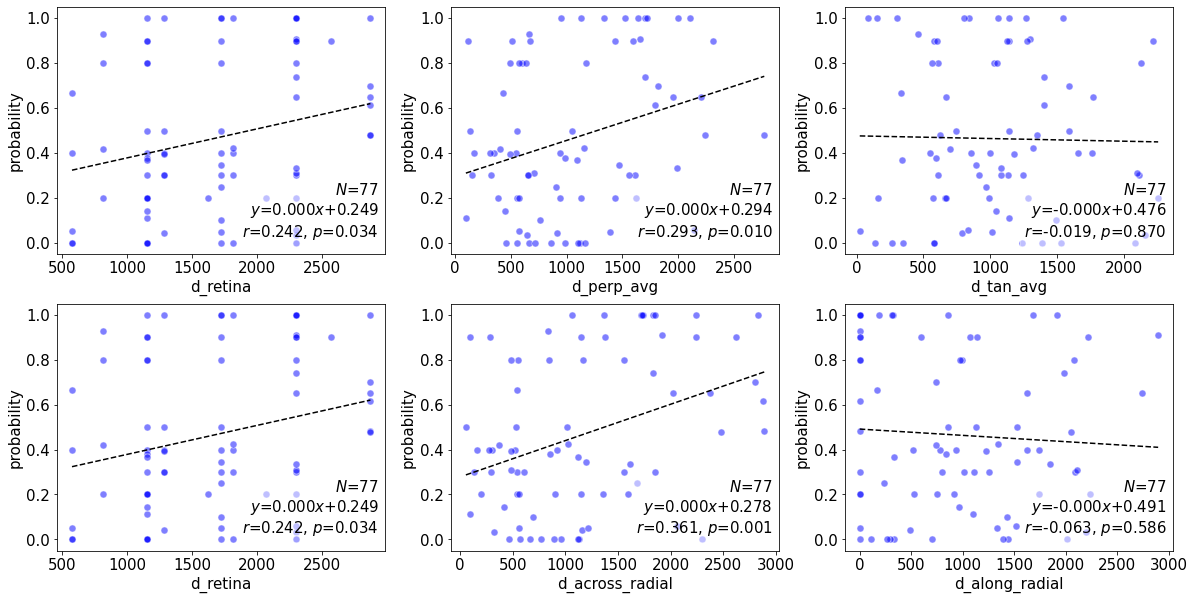

In [68]:

def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

cols = [['d_retina', 'd_perp_avg', 'd_tan_avg'],
    ['d_retina', 'd_across_radial', 'd_along_radial']]
fig, axes = plt.subplots(len(cols), len(cols[0]), figsize=(20, 10))
agg_dict = {col : 'mean' for col in np.unique(np.concatenate(cols))}
agg_dict['num_regions'] = lambda x : np.sum(x >= 2) / len(x)
data_grp = data[(data['stim_class'] == 'MultiElectrode') & (data['d_retina'] < 5000)].groupby(
    ['subject', 'electrode1', 'electrode2',])[list(np.unique(np.concatenate(cols))) + ['num_regions']].agg(agg_dict).reset_index().rename(columns={'num_regions':'probability'})
for idx, (ax_row, col) in enumerate(zip(axes, cols)):
    for i in range(len(col)):
        popt, pcov = curve_fit(sigmoid, data_grp[col[i]], data_grp['probability'], [np.median(data_grp[col[i]]),1], method='dogbox')
        fig.sca(ax_row[i])
        plt.scatter(data_grp[col[i]], data_grp['probability'], color='b', label='data')
        xs = sorted(data_grp[col[i]])
        ys = [sigmoid(x, popt[0], popt[1]) for x in xs]
        r2 = 
        plt.plot(, , color='r', label='sigmoid')
        plt.xlabel(col[i])
        plt.ylabel('probability of >2 phosphenes')
        scatter_correlation(data_grp[col[i]], data_grp['probability'], ax=ax_row[i], show_slope_intercept=True, text_size=15 ,color='b')